In [5]:
import cv2
import numpy as np
import dlib
import RPi.GPIO as GPIO
import threading
import time
from math import hypot
from flask import Flask, render_template, Response
import matplotlib.pyplot as plt

In [ ]:
from cv2 import cuda
cuda.printCudaDeviceInfo(0)

In [ ]:
def gstreamer_pipeline(
    capture_width=1280,
    capture_height=720,
    display_width=1280,
    display_height=720,
    framerate=30,
    flip_method=0,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )




In [ ]:
gpu_frame = cv2.cuda_GpuMat()

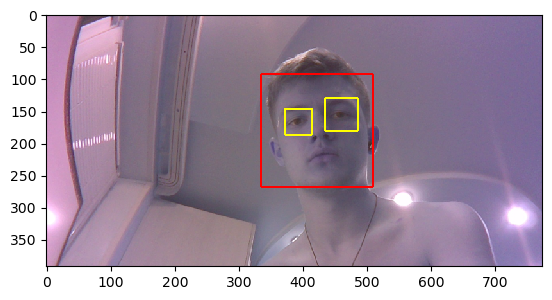

In [30]:

image = cv2.imread('test.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

eyes_cascade = cv2.CascadeClassifier('data/haarcascade_eye_tree_eyeglasses.xml')
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_alt.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(90, 90))
eyes = eyes_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

for (x, y, w, h) in eyes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 0), 2)
        
plt.imshow(image, cmap='gray')

In [1]:
import cv2
image_cpu = cv2.imread('test.png')
cascade_gpu = cv2.cuda.CascadeClassifier_create('haarcascades_cuda/haarcascade_eye_tree_eyeglasses.xml')


In [ ]:
import cv2

image_cpu = cv2.imread('test.png')

image_gpu = cv2.cuda_GpuMat()
image_gpu.upload(image_cpu)

objbuf = cv2.cuda_GpuMat()

cascade_gpu.detectMultiScale(image_gpu, objbuf)

faces = []
cascade_gpu.convert(objbuf, faces)

for rect in faces:
    pt1 = (rect.x, rect.y)
    pt2 = (rect.x + rect.width, rect.y + rect.height)
    cv2.rectangle(image_cpu, pt1, pt2, (255, 0, 0), 2) 

In [ ]:
image_gpu = cv2.cuda_GpuMat()
image_gpu.upload(image_cpu)
cascade_gpu.setScaleFactor(1.2)
cascade_gpu.setMinNeighbors(3)
cascade_gpu.setMinObjectSize((20, 20))


objbuf = cv2.cuda_GpuMat()
cascade_gpu.detectMultiScale(image_gpu, objbuf)

In [3]:


gpu_frame = cv2.cuda_GpuMat()
gpu_frame.upload(image)

gpu_gray = cv2.cuda.cvtColor(gpu_frame, cv2.COLOR_BGR2GRAY)
#face_cascade = cv2.cuda_CascadeClassifier('haarcascades_cuda/haarcascade_frontalface_alt.xml')
stream = cv2.cuda_Stream()


In [4]:
cv2.__file__

'/usr/lib/python3/dist-packages/cv2/__init__.py'

In [2]:
a = cv2.cuda_CascadeClassifier('haarcascades_cuda/haarcascade_eye_tree_eyeglasses.xml')

In [6]:
face_cascade = cv2.cuda.CascadeClassifier('/home/jetson/eyes/haarcascades_cuda/haarcascade_smile.xml')


In [ ]:

image = cv2.imread('test.png')

gpu_frame = cv2.cuda_GpuMat()


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gpu_frame.upload(gray)

face_cascade = cv2.cuda_CascadeClassifier('data/haarcascade_frontalface_alt.xml')


faces_cpu = face_cascade.detectMultiScale(gpu_frame).download()
for (x, y, w, h) in faces_cpu:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
plt.imshow(image, cmap='gray')


In [ ]:
face_cascade = cv2.cuda.CascadeClassifier('data/haarcascade_frontalface_alt.xml')



In [ ]:
def get_frame(cap):
    ret, frame = cap.read()
    if not ret:
        return ret, None
    gpu_frame = cv2.cuda_GpuMat()
    gpu_frame.upload(frame)
    gpu_gray = cv2.cuda.cvtColor(gpu_frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gpu_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    faces_cpu = faces.download()
    
    for (x, y, w, h) in faces_cpu:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return ret, frame

In [ ]:
cap = cv2.VideoCapture(gstreamer_pipeline(flip_method=0), cv2.CAP_GSTREAMER)
app = Flask(__name__)
def post_frames():
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        else:
            _, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')
            
@app.route('/')
def index():
    return render_template('index.html') # Рендер Html
@app.route('/video_feed')
def video_feed():
    return Response(post_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
